In [6]:
# Install the transformers packages
%pip install transformers==4.28.0

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import the required modules:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the GPT-2 model and tokenizer
model_name = 'gpt2'  # You can specify the model size (e.g., 'gpt2', 'gpt2-medium', 'gpt2-large')
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [8]:
# Let's have a closer look at tokenization
ids = [t for t in range(0, 10)]
tokens = tokenizer.convert_ids_to_tokens(ids)
print(f'Ids: {ids}')
print(f'Tokens: {tokens}')

Ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Tokens: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*']


In [9]:
input_sequence = 'Sentence about solar energy.'
tokenizer.encode(input_sequence, return_tensors='pt')

tensor([[31837,   594,   546,  6591,  2568,    13]])

In [10]:
tokenizer.convert_ids_to_tokens([31837,   594,   546,  6591,  2568,    13])

['Sent', 'ence', 'Ġabout', 'Ġsolar', 'Ġenergy', '.']

In [11]:
# Define the input, i.e. your 'prompt'.
input_sequence = 'Sentence about solar energy.'
# input_sequence = 'This is a nonsense sentence.'
# Encode the prompt
encoded_input = tokenizer.encode(input_sequence, return_tensors='pt')

# Generate text using the trained GPT-2 model

max_length = 50  # Maximum length of the generated text
num_return_sequences = 5  # Number of text sequences to generate

# https://huggingface.co/transformers/v4.4.2/main_classes/model.html#generation
output_sequences = model.generate(
    input_ids=encoded_input,
    max_length=max_length,
    num_return_sequences=num_return_sequences,
    temperature=1.0,  # Controls the randomness of the generated text (higher values make it more random)
    repetition_penalty=1.0,  # Penalizes repeating words/phrases (higher values make it less likely to repeat)
    do_sample=True,
    top_k=50,  # Generates from the top k most likely next words
    top_p=0.95,  # Generates from the cumulative probability until it reaches the given probability p
)

# Print the generated text
for i, sequence in enumerate(output_sequences):
    print('\n')
    # Decode the generated text
    generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
    print(f"Generated Text {i+1}: {generated_text}\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




Generated Text 1: Sentence about solar energy.

This article was originally published on The Conversation. Read the original article.



Generated Text 2: Sentence about solar energy.

So far, the results have not been encouraging: there's still little chance of the U.S. government getting permission to build on the site.

The latest review is expected to look at ways to



Generated Text 3: Sentence about solar energy.

For now, she's stuck with her plan for an electric vehicle.

"I think I'm going to be in a completely different position as a mom to a Tesla," says Tysanna. "



Generated Text 4: Sentence about solar energy.

"For me to understand why I am doing this work so seriously is something that I can't wait to do," said the father of two.

"I feel very privileged to work with so many of



Generated Text 5: Sentence about solar energy. This could also be in line with how solar power has played up its prominence in recent years, as well as the state's need for solar photovolt

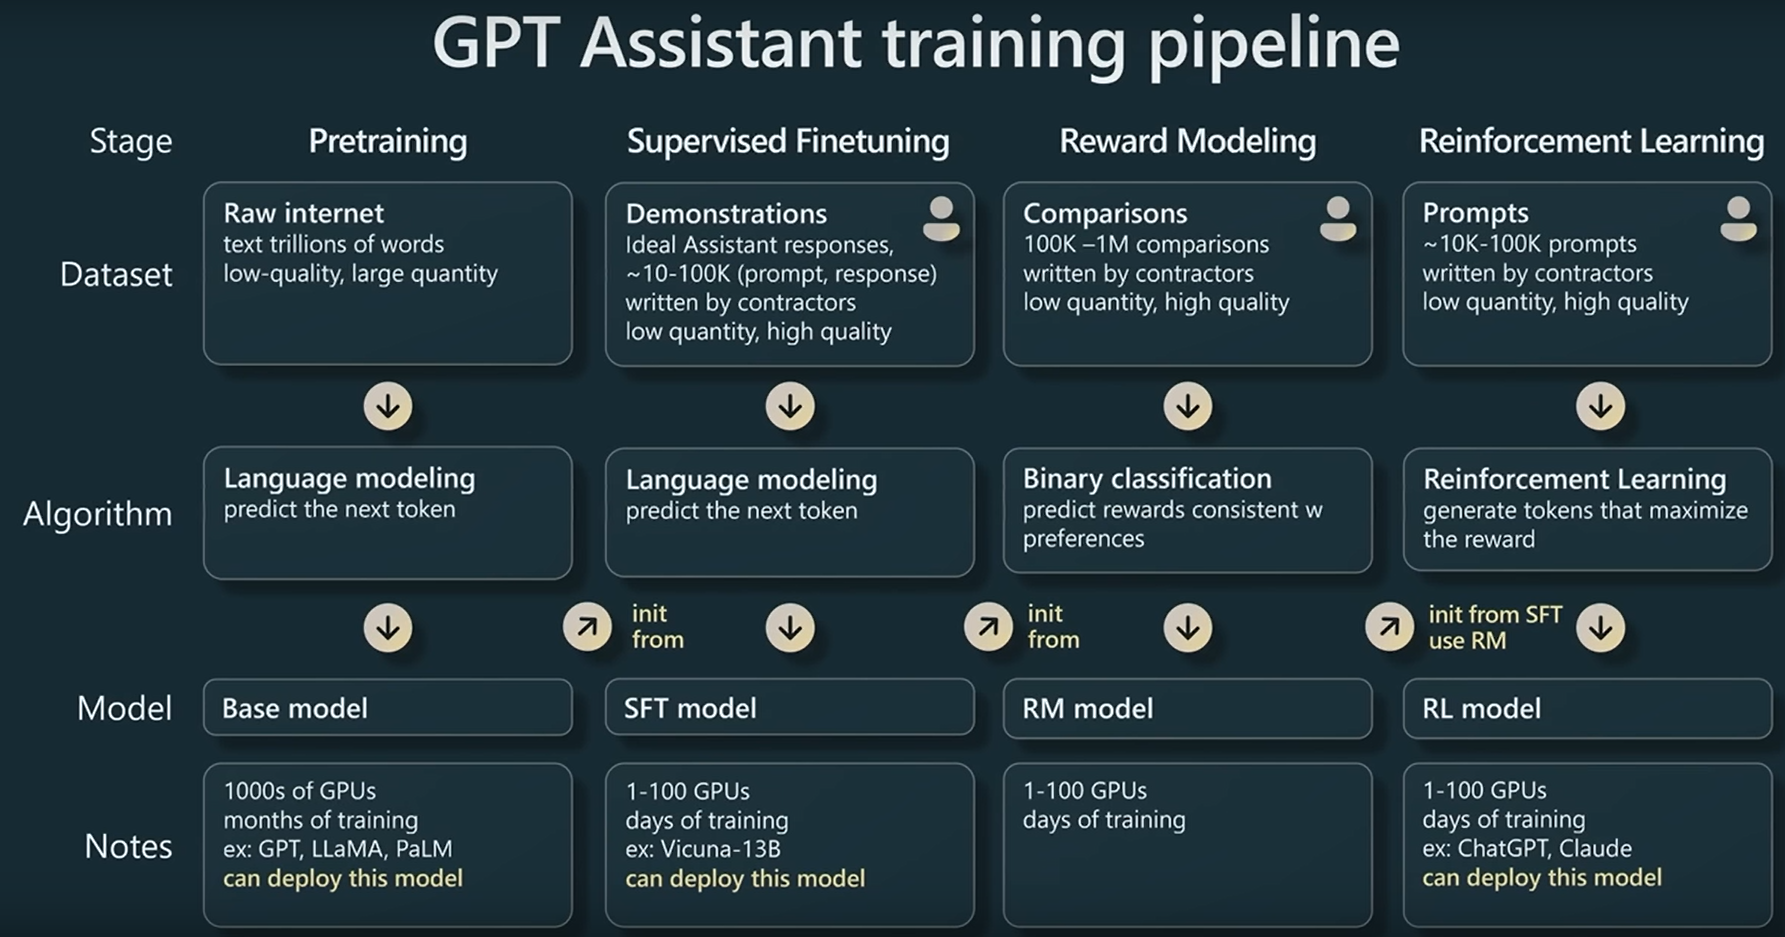

In [13]:
from IPython.display import Image
Image('GPT_training_pipeline.png') # Reference: https://youtu.be/bZQun8Y4L2A?t=76 (retrieved 06-04-2023)

# Fine-tune the GPT2 transformer

## Load a pretrained model

In [14]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling # https://github.com/huggingface/transformers/blob/main/src/transformers/data/datasets/language_modeling.py
from transformers import Trainer, TrainingArguments

model_name = 'gpt2'  # You can specify the model size (e.g., 'gpt2', 'gpt2-medium', 'gpt2-large')
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

## Prepare the dataset

In [16]:
from sklearn.model_selection import train_test_split

train_file_path = 'positive_statements.txt'

# Load the text dataset
dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_file_path,
    block_size=32  # Adjust the block size based on your dataset and memory capacity
)

# Split into train, eval and test sets
train_set, test_set = train_test_split(dataset, test_size=0.33, random_state=42)
eval_set, test_set = train_test_split(test_set, test_size=0.1, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


## Fine-tune the model on your dataset

In [17]:
import time

start_time = time.time()
# Create a data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

output_dir = 'trained_models'  # Create the directory if it doesn't exist

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,  # Specify the number of training epochs
    per_device_train_batch_size=64,  # Adjust the batch size based on your memory capacity
    save_steps=1000,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=1e-4,  # Adjust the learning rate as needed
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_set,
    eval_dataset=eval_set,
)

# Start the fine-tuning process
trainer.train()

elapsed_time = time.time()-start_time
print(f'Elapsed time: {elapsed_time}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

{'train_runtime': 38.7576, 'train_samples_per_second': 11.146, 'train_steps_per_second': 0.232, 'train_loss': 3.6423958672417536, 'epoch': 3.0}
Elapsed time: 38.830434799194336


In [18]:
trainer.save_model('trained_models/final_finetuned_gpt2')

## Test the fine-tuned model

In [19]:
model_name = 'trained_models/final_finetuned_gpt2'
finetuned_model = GPT2LMHeadModel.from_pretrained(model_name, local_files_only=True)

In [20]:
text = "Sentence about solar energy."
# text = "This is a nonsense sentence."
# text = "A goat went crazy and tripped on mushrooms."
text = "The analyst shared stock market insights with the Financial Times."

# Tokenize the input text
input_ids = tokenizer.encode(text, return_tensors='pt')

# Generate text using the trained GPT-2 model
max_length = 50  # Maximum length of the generated text
num_return_sequences = 10  # Number of text sequences to generate

# https://huggingface.co/transformers/v4.4.2/main_classes/model.html#generation
output_sequences = finetuned_model.generate(
    input_ids=input_ids,
    max_length=max_length,
    num_return_sequences=num_return_sequences,
    temperature=1.0,  # Controls the randomness of the generated text (higher values make it more random)
    repetition_penalty=1.0,  # Penalizes repeating words/phrases (higher values make it less likely to repeat)
    do_sample=True,
    top_k=50,  # Generates from the top k most likely next words
    top_p=0.95,  # Generates from the cumulative probability until it reaches the given probability p
)

# Decode and print the generated text
for output in output_sequences:
  print('\n')
  # Decode the generated text
  generated_text = tokenizer.decode(output, skip_special_tokens=True)
  print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




The analyst shared stock market insights with the Financial Times.
He said that with better data, an efficient blockchain could take the world's biggest financial services.
He suggested using a smart wallet for both banking and investment, a way to benefit from a


The analyst shared stock market insights with the Financial Times.
Brent-free money.
An independent central bank.
Solar power to help make a brighter day.
The solar panel's energy independence.
Solar panels deliver a clean energy future


The analyst shared stock market insights with the Financial Times.
They also shared with the Financial Times.
They shared with the FT.
The energy giants like Renewable power.
Solar panels and geo-friendly power.
Solar panels and bi


The analyst shared stock market insights with the Financial Times.
In case you haven't heard about the recent developments in data and technology.
Fiat paper thinning: solar energy saving power.
Solar power: cutting-edge solar panel solutions for


The analys

# Fine tuning into a Classifier
GPT is a gnerative AI model, not designed for Classification tasks.
However, there are many other models out there. Here, we will use ROBERTa.
ROBERTa: https://huggingface.co/transformers/v4.4.2/model_doc/roberta.html

Fine tuning tutorial: https://huggingface.co/transformers/v3.2.0/custom_datasets.html

## Load and prepare the dataset

In [21]:
positive_text = ''

with open('positive_statements.txt', 'r') as pos_file:
  positive_text = pos_file.read()

positive_seqs = positive_text.split('\n')
positive_labels = [1]*len(positive_seqs)

In [22]:
negative_text = ''

with open('negative_statements.txt', 'r') as neg_file:
  negative_text = neg_file.read()

negative_seqs = negative_text.split('\n')
negative_labels = [0]*len(negative_seqs)

In [23]:
import numpy as np

texts = np.array(positive_seqs + negative_seqs)
texts = np.array([text.replace(':', '') for text in texts])
labels = np.array(positive_labels + negative_labels)

# Select only a small part of the data to reduce training time!
ids_to_select = np.array(range(0, len(labels)))
np.random.shuffle(ids_to_select)
ids_to_select = ids_to_select[:400]
texts = texts[ids_to_select]
labels = labels[ids_to_select]

In [24]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.33, random_state=35858)

eval_texts, test_texts, eval_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.1, random_state=234)

In [25]:
for i in range(0, 10):
  sentiment = 'positive' if train_labels[i] else 'negative'
  print(f'Sentence: {train_texts[i]} Sentiment: {sentiment}')

Sentence: Incompatibility with existing infrastructure creates integration challenges. Sentiment: negative
Sentence: Rigmarole maintenance neglect consequences. Sentiment: negative
Sentence: Solar panles make a positve impact on the environment. Sentiment: positive
Sentence: Solar panels generate electricity from a renewable source. Sentiment: positive
Sentence: Solar energy alone cannot replace the entire fossil fuel infrastructure. Sentiment: negative
Sentence: Solar panels contrbute to a cleaneer environment. Sentiment: positive
Sentence: Solar, a false light that leads us astray, away from nature's true path. Sentiment: negative
Sentence: Solar panels whifflewaffling bright energy. Sentiment: positive
Sentence: Embrace solar pannels and contribute to a clener planet. Sentiment: positive
Sentence: Solar panel production has its own environmental impacts. Sentiment: negative


In [26]:
class SolarDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Tokenize using ROBERTa tokenizer

In [27]:
from transformers import SqueezeBertTokenizerFast
tokenizer = SqueezeBertTokenizerFast.from_pretrained('squeezebert/squeezebert-uncased')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Compute the tokens
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='pt')
eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors='pt')

# Create the datasets
train_dataset = SolarDataset(train_encodings, train_labels)
eval_dataset = SolarDataset(eval_encodings, eval_labels)
test_dataset = SolarDataset(test_encodings, test_labels)

## Load a pretrained ROBERTa model

In [28]:
from transformers import SqueezeBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./classification_results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./classification_logs',            # directory for storing logs
    logging_steps=10,
)

# Following the 🤗 recommendation for the choice of the pretrained model:
# https://huggingface.co/transformers/v4.4.2/model_doc/squeezebert.html#overview
classifier_model = SqueezeBertForSequenceClassification.from_pretrained("squeezebert/squeezebert-mnli-headless")

classifier_trainer = Trainer(
    model=classifier_model,              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset            # evaluation dataset
)

classifier_trainer.train()

Some weights of SqueezeBertForSequenceClassification were not initialized from the model checkpoint at squeezebert/squeezebert-mnli-headless and are newly initialized: ['classifier.weight', 'transformer.pooler.dense.weight', 'classifier.bias', 'transformer.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/17 [00:00<?, ?it/s]

/var/folders/wj/tvdm7qp11rlf5k20r5kb0qg80000gq/T/ipykernel_35084/167682926.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6452, 'learning_rate': 2.058823529411765e-05, 'epoch': 0.59}
{'train_runtime': 70.4467, 'train_samples_per_second': 3.804, 'train_steps_per_second': 0.241, 'train_loss': 0.6103108770707074, 'epoch': 1.0}


TrainOutput(global_step=17, training_loss=0.6103108770707074, metrics={'train_runtime': 70.4467, 'train_samples_per_second': 3.804, 'train_steps_per_second': 0.241, 'train_loss': 0.6103108770707074, 'epoch': 1.0})

In [29]:
classifier_trainer.save_model('trained_models/final_finetuned_squeezebert_classifier')

In [30]:
model_name = 'trained_models/final_finetuned_squeezebert_classifier'
classifier_model = SqueezeBertForSequenceClassification.from_pretrained(model_name, local_files_only=True)
classifier_model.eval()

SqueezeBertForSequenceClassification(
  (transformer): SqueezeBertModel(
    (embeddings): SqueezeBertEmbeddings(
      (word_embeddings): Embedding(30528, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): SqueezeBertEncoder(
      (layers): ModuleList(
        (0-11): 12 x SqueezeBertModule(
          (attention): SqueezeBertSelfAttention(
            (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
            (matmul_qk): MatMulWrapper()
            (matmul_qkv): MatMulWrapper()
          )
          (post_attention)

In [31]:
# Forward pass
with torch.no_grad():
    outputs = classifier_model(**test_dataset.encodings)

# Get the predicted logits
logits = outputs.logits

# Get the predicted probabilities
probs = torch.softmax(logits, dim=1)

# Get the predicted labels (0 or 1)
y_pred = torch.argmax(probs, dim=1)

In [32]:
from sklearn.metrics import classification_report

y_test = test_dataset.labels

scores = classification_report(y_test, y_pred)
print(scores)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         4

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [33]:
example = 'Solar panels a clean source of energy.'
# example = 'A threat to humanity.'
# example = 'Solar panels are a dangerous threat to humanity.'
# example = "This is a nonsense sentence."
# example = "A goat went crazy and tripped on mushrooms."

example_encoding = tokenizer([example], truncation=True, padding=True, return_tensors='pt')

# Forward pass
with torch.no_grad():
    outputs = classifier_model(**example_encoding)

# Get the predicted logits
logits = outputs.logits

# Get the predicted probabilities
probs = torch.softmax(logits, dim=1)

# Get the predicted labels (0 or 1)
y_pred = torch.argmax(probs, dim=1)

result = 'Funny' if 'goat' in example else'Positive' if y_pred==1 else 'Negative'
print(result)

Positive


# Assignment: try to improve the model prediction performance
- Try running the above with a bigger dataset
- Try finetuning some of the hyperparameters
- Try out other models available on 🤗